In [1]:
import math
import random
import sys
from scipy import special
from tqdm import trange
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Construct a network graph and compute the d-hop neighborhood of each node. Use addEdge(i, j) to add an undirected edge between node i and j. After finishing the process of adding edges, call finishAddingEdges, so the object will construct d-hop adjacency matrices for $d \leq k$. Call findNeighbors(i, d) to get the d-hop neighborhood of node i.

In [2]:
class GlobalNetwork:
    def __init__(self, nodeNum, k):
        self.nodeNum = nodeNum #the total number of nodes in this network
        self.adjacencyMatrix = np.eye(self.nodeNum, dtype = int) #initialize the adjacency matrix of the global network
        self.k = k #the number of hops used in learning
        self.adjacencyMatrixPower = [np.eye(self.nodeNum, dtype = int)] #cache the powers of the adjacency matrix
        self.neighborDict = {} #use a hashmap to store the ((node, dist), neighbors) pairs which we have computed
        self.addingEdgesFinished = False #have we finished adding edges?
    
    #add an undirected edge between node i and j
    def addEdge(self, i, j):
        self.adjacencyMatrix[i, j] = 1
        self.adjacencyMatrix[j, i] = 1
    
    #finish adding edges, so we can construct the k-hop neighborhood after adding edges
    def finishAddingEdges(self):
        temp = np.eye(self.nodeNum, dtype = int)
        #the d-hop adjacency matrix is stored in self.adjacencyMatrixPower[d]
        for _ in range(self.k):
            temp = np.matmul(temp, self.adjacencyMatrix)
            self.adjacencyMatrixPower.append(temp)
        self.addingEdgesFinished = True
        print(self.adjacencyMatrixPower)
    
    #query the d-hop neighborhood of node i, return a list of node indices.
    def findNeighbors(self, i, d):
        if not self.addingEdgesFinished:
            print("Please finish adding edges before call findNeighbors!")
            return -1
        if (i, d) in self.neighborDict: #if we have computed the answer before, return it
            return self.neighborDict[(i, d)]
        neighbors = []
        for j in range(self.nodeNum):
            if self.adjacencyMatrixPower[d][i, j] > 0: #this element > 0 implies that dist(i, j) <= d
                neighbors.append(j)
        self.neighborDict[(i, d)] = neighbors #cache the answer so we can reuse later
        return neighbors

Class AccessNetwork inherits class GlobalNetwork. It is designed for Wireless network with multiple access points example. It provides API, addAccess, for adding an access point of a (user) node. After finishing the process of adding access points, call finishAddingAccess to construct the adjacency graph of (user) nodes. Two nodes are neighbors iff they share at least one access point.

In [3]:
class AccessNetwork(GlobalNetwork):
    def __init__(self, nodeNum, k, accessNum):
        super(AccessNetwork, self).__init__(nodeNum, k)
        self.accessNum = accessNum
        self.accessMatrix = np.zeros((nodeNum, accessNum), dtype = int)
    
    #add an access point a for node i
    def addAccess(self, i, a):
        self.accessMatrix[i, a] = 1
        
    #finish adding access points. we can construct the neighbor graph
    def finishAddingAccess(self):
        #use accessMatrix to construct the adjacency matrix of (user) nodes
        self.adjacencyMatrix = np.matmul(self.accessMatrix, np.transpose(self.accessMatrix))
        
        #calculate the number of users sharing each access point
        self.numNodePerAccess = np.sum(self.accessMatrix,axis = 0)
        
        super(AccessNetwork, self).finishAddingEdges()
    
    #find the access points for node i
    def findAccess(self, i):
        accessPoints = []
        for j in range(self.accessNum):
            if self.accessMatrix[i, j] > 0:
                accessPoints.append(j)
        return accessPoints
    def setTransmitProb(self,transmitProb):
        self.transmitProb = transmitProb

Given the total number of nodes (nodeNum) and the number of nodes per block (nodePerBlock), construct a network with the structure shown below:
<img src="IMG/Experiment1-Graph.png" alt="Drawing" style="width: 600px;">

In [4]:
def constructLinearNetwork(nodeNum, k, nodePerBlock , transmitProb = 'allone'):
    #compute the number of access points
    accessNum = (nodeNum - 1)//nodePerBlock
        
    if accessNum <= 0:
        print("nodeNum is not large enough!")
        return null
    accessNetwork = AccessNetwork(nodeNum = nodeNum, k = k, accessNum = accessNum)
    for i in range(nodeNum):
        j = i//nodePerBlock
        if j >= 1:
            accessNetwork.addAccess(i, j - 1)
        if j < accessNum:
            accessNetwork.addAccess(i, j)
    accessNetwork.finishAddingAccess()
    
    
    # setting transmitProb 
    if transmitProb == 'allone':
        transmitProb = np.ones(accessNum)
    elif transmitProb == 'random':
        transmitProb = np.random.rand(accessNum)
    
    accessNetwork.setTransmitProb(transmitProb)
    return accessNetwork

In [5]:
def constructGridNetwork(nodeNum, width, height, k, nodePerGrid, transmitProb = 'allone'):
    if nodeNum != width * height * nodePerGrid:
        print("nodeNum does not satisfy the requirement of grid network!", nodeNum, width, height, nodePerGrid)
        return null
    accessNum = (width - 1) * (height - 1)
    accessNetwork = AccessNetwork(nodeNum = nodeNum, k = k, accessNum = accessNum)
    for j in range(accessNum):
        upperLeft = j//(width - 1) * width + j%(width - 1)
        upperRight = upperLeft + 1
        lowerLeft = upperLeft + width
        lowerRight = lowerLeft + 1
        for a in [upperLeft, upperRight, lowerLeft, lowerRight]:
            for b in range(nodePerGrid):
                accessNetwork.addAccess(nodePerGrid * a + b, j)
    accessNetwork.finishAddingAccess()
    
    # setting transmitProb 
    if transmitProb == 'allone':
        transmitProb = np.ones(accessNum)
    elif transmitProb == 'random':
        transmitProb = np.random.rand(accessNum)
    
    accessNetwork.setTransmitProb(transmitProb)

    return accessNetwork

Specify the total number of nodes (nodeNum) and the size of neighborhood we should consider in the learning process. Construct the access network.

Class Node specifies what should be implemented by a (user) node in the global network. It maintains the history record of its local trajectory as well as its k-hop neighbors' (state, action) trajectory in the learning process.

The offspring of this class should implement:
1. initializeState: pick the initial state of this (user) node;
2. updateState: based on neighbors' states and actions at the last time step, pick the current local state;
3. updateAction: based on the local state (or neighbors' states), pick the current action;
4. updateReward: based the neighbors' current states and actions, decide the current local reward;
5. updateQ: based on $(s_{N_i^k}(t-1), a_{N_i^k}(t-1), r_i(t-1), s_{N_i^k}(t), a_{N_i^k}(t))$, update the Q function;
6. updateParams: using the recorded trajectory and the Q dictionary to update the policy parameters.

In [6]:
class Node:
    def __init__(self, index):
        self.index = index
        self.state = [] #The list of local state at different time steps
        self.action = [] #The list of local actions at different time steps
        self.reward = [] #The list of local actions at different time steps
        self.currentTimeStep = 0 #Record the current time step.
        self.paramsDict = {} #use a hash map to query the parameters given a state (or neighbors' states)
        self.QDict = {} #use a hash map to query to the Q value given a (state, action) pair
        self.kHop = [] #The list to record the (state, action) pairs of k-hop neighbors
    #get the local Q at timeStep
    def getQ(self, kHopStateAction):
        #if the Q value of kHopStateAction hasn't been queried before, return 0.0 (initial value)
        return self.QDict.get(kHopStateAction, 0.0)
    
    #initialize the local state
    def initializeState(self):
        pass
    #update the local state, it may depends on the states of other nodes at the last time step.
    #Remember to increase self.currentTimeStep by 1
    def updateState(self):
        pass
    #update the local action
    def updateAction(self):
        pass
    #update the local reward
    def updateReward(self):
        pass
    #update the local Q value
    def updateQ(self):
        pass
    #update the local parameter
    def updateParams(self):
        pass
    #clear the record. Called when a new inner loop starts. 
    def restart(self, clearPolicy = False, clearQ = False):
        self.state.clear()
        self.action.clear()
        self.reward.clear()
        
        if(clearPolicy == True):
            self.paramsDict.clear()
        if(clearQ == True):
            self.QDict.clear()
        self.kHop = []
        self.currentTimeStep = 0

In [7]:
class accessNodeDiscounted(Node):
    def __init__(self, index, ddl, arrivalProb, accessNetwork, gamma):
        super(accessNodeDiscounted, self).__init__(index)
        self.ddl = ddl #the initial deadline of each packet
        self.arrivalProb = arrivalProb #the arrival probability at each timestep
        #we use packetQueue to represent the current local state, which is (e_1, e_2, ..., e_d)
        self.packetQueue = np.zeros(self.ddl, dtype = int) #use 1 to represent a packet with this remaining time, otherwise 0
        self.accessPoints = accessNetwork.findAccess(i=index) #find and cache the access points this node can access
        self.accessNum = len(self.accessPoints) #the number of access points
        self.actionNum = self.accessNum  + 1 #the number of possible actions
        self.stateNum = 2** self.ddl # number of possible states
        self.gamma = gamma # discounting factor
        
        #construct a list of possible actions
        self.actionList = [-1] #(-1, -1) is an empty action that does nothing
        for a in self.accessPoints:
            self.actionList.append(a)
        
        # set default policy
        self.defaultPolicy = np.zeros(self.actionNum)
        self.defaultPolicy[0] = 2

    #remove the first element in packetQueue, and add packetState to the end
    def rotateAdd(self, packetState):
        #print('self.packetQueue[1:] =',self.packetQueue[1:],'self.ddl = ',self.ddl, 'packetState = ',packetState )
        self.packetQueue = np.insert(self.packetQueue[1:], self.ddl - 1, packetState)
        #print('new = ',self.packetQueue)
        
    #initialize the local state (called at the beginning of the training process)
    def initializeState(self):
        newPacketState = np.random.binomial(1, self.arrivalProb) #Is there a packer arriving at time step 0?
        self.rotateAdd(newPacketState) #get the packet queue at time step 0
        self.state.append(tuple(self.packetQueue)) #append this state to state record
    
    #At each time step t, call updateState, updateAction, updateReward, updateQ in this order
    def updateState(self):
        self.currentTimeStep += 1
        lastAction = self.action[-1]
        
        # find the earliest slot
        nonEmptySlots = np.nonzero(self.packetQueue == 1)
        
        if len(nonEmptySlots) >0: # queue not empty
            #if the reward at the last time step is positive, we have successfully send out a packet
            if self.reward[-1] > 1 - 1e-3:
                self.packetQueue[nonEmptySlots[0]] = 0 # earliest packet is sent
        
        #sample whether next packet comes
        newPacketState = np.random.binomial(1, self.arrivalProb) #Is there a packer arriving at time step 0?
        self.rotateAdd(newPacketState) #get the packet queue at time step 0
        self.state.append(tuple(self.packetQueue)) #append this state to state record
            
        
    def updateAction(self):
        # get the current state
        currentState = tuple(self.packetQueue)
        # fetch the params based on the current state. If haven't updated before, return all zeros
        params = self.paramsDict.get(currentState, np.zeros(self.actionNum))
        # compute the probability vector
        probVec = special.softmax(params)
        # randomly select an action based on probVec
        currentAction = self.actionList[np.random.choice(a = self.actionNum, p = probVec)]
        
        self.action.append(currentAction)
    
    #oneHopNeighbors is a list of accessNodes
    def updateReward(self, oneHopNeighbors, accessNetwork):
        #decide if a packet is successfully sending out
        currentAction = self.action[-1]
        if currentAction == -1: # the do nothing action
            self.reward.append(0.0)
            return
        currentState = np.array(self.state[-1])
        
        #check if the node try to send out an empty slot
        if np.all(currentState == 0): # if the current queue is empty
            # zero reward
            self.reward.append(0.0)
        
        for neighbor in oneHopNeighbors:
            if neighbor.index == self.index:
                continue
            neighborAction = neighbor.action[-1]
            
            if neighborAction != currentAction: 
                continue
            else:
                neighborState = np.array(neighbor.state[-1])
                #print('neighborState', neighborState)
                if np.any(neighborState == 1): # neighbor queue non empty, conflict!
                    #print('conflict!')
                    self.reward.append(0.0)
                    return
        
        # no conflict, send
        transmitSuccess = np.random.binomial(1, accessNetwork.transmitProb[currentAction])
        if transmitSuccess == 1:
            self.reward.append(1.0)
        else:
            self.reward.append(0.0)

                                
    
    #kHopNeighbors is a list of accessNodes, alpha is learning rate
    def updateQ(self, kHopNeighbors, alpha):
        lastStateAction = []
        currentStateAction = []
        #construct a list of the state-action pairs of k-hop neighbors
        for neighbor in kHopNeighbors:
            neighborLastState = neighbor.state[-2]
            neighborCurrentState = neighbor.state[-1]
            neighborLastAction = neighbor.action[-2]
            neighborCurrentAction = neighbor.action[-1]
            lastStateAction.append((neighborLastState, neighborLastAction))
            currentStateAction.append((neighborCurrentState, neighborCurrentAction))
        lastStateAction = tuple(lastStateAction)
        currentStateAction = tuple(currentStateAction)
        #fetch the Q value based on neighbors' states and actions
        lastQTerm1 = self.QDict.get(lastStateAction, 0.0)
        lastQTerm2 = self.QDict.get(currentStateAction, 0.0)
        #compute the temporal difference                
        temporalDiff = self.reward[-2] +  self.gamma*lastQTerm2 - lastQTerm1
        #print('lastStateAction',lastStateAction)
        #perform the Q value update 
        self.QDict[lastStateAction] = lastQTerm1 + alpha * temporalDiff

        # if this time step 1, we should also put lastStateAction into history record
        if len(self.kHop) == 0:
            self.kHop.append(lastStateAction)
            
        #put currentStateAction into history record
        self.kHop.append(currentStateAction)
    
    #eta is the learning rate
    def updateParams(self, kHopNeighbors, eta):
        #for t = 0, 1, ..., T, compute the term in g_{i, t}(m) before \nabla
        mutiplier1 = np.zeros(self.currentTimeStep + 1)
        for neighbor in kHopNeighbors:
            for t in range(self.currentTimeStep + 1):
                neighborKHop = neighbor.kHop[t]
                neighborQ = neighbor.getQ(neighborKHop)
                mutiplier1[t] += neighborQ
        
        for t in range(self.currentTimeStep + 1):
            mutiplier1[t] *= pow(self.gamma, t)
            mutiplier1[t] /= nodeNum
        
        #finish constructing mutiplier1
        #compute the gradient with respect to the parameters associated with s_i(t)
        for t in range(self.currentTimeStep + 1):
            currentState = self.state[t]
            currentAction = self.action[t]
            params = self.paramsDict.get(currentState, self.defaultPolicy)
            probVec = special.softmax(params)
            grad = -probVec
            actionIndex = self.actionList.index(currentAction)
            grad[actionIndex] += 1.0
            self.paramsDict[currentState] = params + eta * mutiplier1[t] * grad


    def setBenchmarkPolicy(self,accessNetwork,noactionProb): # set a naive benchmarkPolicy
        proportionAction = []
        for actionCounter in range(self.actionNum):
            if self.actionList[actionCounter] == -1:
                proportionAction.append(np.log(100*noactionProb/4.0))
            else:
                numNodePerAccess = float(accessNetwork.numNodePerAccess[self.actionList[actionCounter]])
                transmitProb = float(accessNetwork.transmitProb[self.actionList[actionCounter]])
                print('numNodePerAccess = ',numNodePerAccess,' transmitProb = ',transmitProb)
                proportionAction.append( np.log(100*transmitProb/numNodePerAccess))
            
        
        for stateInt in range(self.stateNum): # enumerate state
            currentState = self.int2state(stateInt) # turn state integer into binary list
            actionParams = np.ones(self.actionNum,dtype = float) * (-10) # default to be all negative
            
            
            if np.all( currentState == 0): # no packet in queue
                actionParams[0] = 10.0 # do nothing
            else:
                actionParams = np.array(proportionAction) # proportional action
            # update paramsDict
            self.paramsDict[tuple(currentState)] = actionParams
                
            
        
    def int2state(self,stateInt):
        currentState = np.zeros(self.ddl,dtype = int)
        stateIntIterate = stateInt
        for i in range(ddl):
            currentState[i] = stateIntIterate% self.ddl
            stateIntIterate = stateIntIterate//self.ddl
        return currentState

In [8]:
class MultiAccessNetworkRL:
    def __init__(self,ddl = 2, graphType = 'line', nodeNum = 10, maxK = 3 ,arrivalProb = None, transmitProb = 'random', gridW = 1, gridH = 1, gamma = 0.7):
        self.ddl = ddl
        self.nodeNum = nodeNum
        self.gamma = gamma
        self.maxK = maxK
        if(arrivalProb == None):
            self.arrivalProb = np.random.rand(nodeNum)
        else:
            self.arrivalProb = arrivalProb
            
        if graphType == 'line':
            self.accessNetwork = constructLinearNetwork(nodeNum = nodeNum, nodePerBlock = 1, k = maxK,transmitProb= transmitProb)
        else:
            self.accessNetwork =  constructGridNetwork(nodeNum = nodeNum, width = gridW, height = gridH, k = maxK, nodePerGrid = 1,transmitProb= transmitProb)
            
        self.nodeList = []
        for i in range(nodeNum):
            self.nodeList.append(accessNodeDiscounted(index = i, ddl = ddl, arrivalProb = self.arrivalProb[i], accessNetwork = self.accessNetwork, gamma = gamma) )
       
    def train(self, k = 1, M = 10000, T = 20, evalInterval = 500, restartIntervalQ = 50, restartIntervalPolicy = 50, evalM = 500, clearPolicy = True):
            
        
        policyRewardList = []
        policyRewardSmooth = []
        
        for m in trange(M):
            discountedReward = 0.0 # total reward for this 
            
            
            # restart node
            for i in range(self.nodeNum):
                if(m == 0):
                    self.nodeList[i].restart(clearPolicy = clearPolicy, clearQ = True)
                else:
                    self.nodeList[i].restart(clearPolicy = False, clearQ = False)
                self.nodeList[i].initializeState()
                self.nodeList[i].updateAction()
            
            tmpReward = 0.0
            for i in range(self.nodeNum):
                neighborList = []
                for j in self.accessNetwork.findNeighbors(i, 1):
                    neighborList.append(self.nodeList[j])
                self.nodeList[i].updateReward(neighborList,self.accessNetwork)
                tmpReward += self.nodeList[i].reward[-1]
            discountedReward += tmpReward/self.nodeNum
            
            for t in range(T):
                for i in range(self.nodeNum): #update state-action
                    self.nodeList[i].updateState()
                    self.nodeList[i].updateAction()
                tmpReward = 0.0
                for i in range(self.nodeNum):
                    neighborList = []
                    for j in self.accessNetwork.findNeighbors(i, 1):
                        neighborList.append(self.nodeList[j])
                    self.nodeList[i].updateReward(neighborList,self.accessNetwork)

                    tmpReward += self.nodeList[i].reward[-1] # add latest reward
                discountedReward += (self.gamma**(t+1))*tmpReward/self.nodeNum
                # Update Q-function
                for i in range(self.nodeNum):
                    neighborList = []
                    for j in self.accessNetwork.findNeighbors(i, k):
                        neighborList.append(self.nodeList[j])
                    self.nodeList[i].updateQ(neighborList, 1/pow((m%restartIntervalQ)+1,.4)  )
            
            policyRewardList.append(discountedReward)
            

            #perform the grad update
            for i in range(self.nodeNum):
                neighborList = []
                for j in self.accessNetwork.findNeighbors(i, k):
                    neighborList.append(self.nodeList[j])
                self.nodeList[i].updateParams(neighborList,  1.0* 1/pow((m%restartIntervalPolicy)+1,.6))
                
            #print(m%restartIntervalPolicy)
            if m > M*0.9: # for the last 10% of running, no restarting
                restartIntervalQ = max(int(M*0.5),restartIntervalQ)
                restartIntervalPolicy = max(int(M*0.5),restartIntervalPolicy)
            
            # perform a policy evaluation
            if m%evalInterval == 0:
                policyRewardSmooth.append(self.policyEval(evalM , T ) )
        
        return policyRewardSmooth
    
    def policyEval(self, evalM, T):
        aveReward = 0.0
        for m in range(evalM):
            # restart policy 
            discountedReward = 0.0
            tmpReward = 0.0
            for i in range(self.nodeNum):
                self.nodeList[i].restart(clearPolicy = False, clearQ = False)
                self.nodeList[i].initializeState()
                self.nodeList[i].updateAction()

            tmpReward = 0.0
            for i in range(self.nodeNum):
                neighborList = []
                for j in self.accessNetwork.findNeighbors(i, 1):
                    neighborList.append(self.nodeList[j])
                self.nodeList[i].updateReward(neighborList,self.accessNetwork)
                tmpReward += self.nodeList[i].reward[-1]
            discountedReward += tmpReward/self.nodeNum

            for t in range(T):
                for i in range(self.nodeNum): #update state-action
                    self.nodeList[i].updateState()
                    self.nodeList[i].updateAction()
                tmpReward = 0.0
                for i in range(self.nodeNum):
                    neighborList = []
                    for j in self.accessNetwork.findNeighbors(i, 1):
                        neighborList.append(self.nodeList[j])
                    self.nodeList[i].updateReward(neighborList,self.accessNetwork)

                    tmpReward += self.nodeList[i].reward[-1] # add latest reward
                discountedReward += (self.gamma**(t+1))*tmpReward/self.nodeNum

            aveReward += discountedReward
        return aveReward/evalM

    
    def evaluateBenchmarkPolicy(self, evalM, T, noactionProb):
        for i in range(self.nodeNum):
            self.nodeList[i].setBenchmarkPolicy(self.accessNetwork,noactionProb)

        return self.policyEval(evalM ,T)


Specify hyper-parameters before training. T is the length of the inner loop; M is the length of the outer loop.

In [9]:
ddl = 2

np.random.seed(0)

# linear network
# nodeNum = 6 #number of nodes in the network
# maxK = 2 #the size of neighborhood we use in localized learning
# arrivalProb = [.3,.9, .9] *2
# transmitProb = [ .9,.9]   + [.02, .9, .9 ]*1
# gamma = .7
# networkRLModel = MultiAccessNetworkRL(ddl = 2, graphType = 'line', \
#                                       nodeNum = nodeNum, maxK = maxK ,arrivalProb = arrivalProb,transmitProb = transmitProb, gamma = gamma)
# M = 10000
# T = 10

# evalInterval = 500 #evaluate the policy every evalInterval rounds (outer loop)
# evalM = 1000 # number of episodes when doing evaluation
# restartIntervalQ = 500
# restartIntervalPolicy = 500


gridW = 6
gridH = 6
nodeNum = gridW*gridH #number of nodes in the network
maxK = 2 #the size of neighborhood we use in localized learning
arrivalProb = None
transmitProb = 'random'
gamma = 0.7
networkRLModel = MultiAccessNetworkRL(ddl = 2, graphType = 'grid', \
                                      nodeNum = nodeNum, maxK = maxK ,arrivalProb = arrivalProb,transmitProb = transmitProb,gridW = gridW, gridH = gridH, gamma = 0.7)

M = 50000
T = 8

evalInterval = 2000 #evaluate the policy every evalInterval rounds (outer loop)
evalM = 150
restartIntervalQ = 10
restartIntervalPolicy = 10

np.random.seed()






[array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]]), array([[1, 1, 0, ..., 0, 0, 0],
       [1, 2, 1, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 1, 0],
       [0, 0, 0, ..., 1, 2, 1],
       [0, 0, 0, ..., 0, 1, 1]]), array([[ 4,  6,  2, ...,  0,  0,  0],
       [ 6, 12,  8, ...,  0,  0,  0],
       [ 2,  8, 12, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 12,  8,  2],
       [ 0,  0,  0, ...,  8, 12,  6],
       [ 0,  0,  0, ...,  2,  6,  4]])]


In [10]:
benchMarkReward = networkRLModel.evaluateBenchmarkPolicy(evalM , T,.1)

print('benchmark reward is: ', benchMarkReward)

numNodePerAccess =  4.0  transmitProb =  0.6120957227224214
numNodePerAccess =  4.0  transmitProb =  0.6120957227224214
numNodePerAccess =  4.0  transmitProb =  0.6169339968747569
numNodePerAccess =  4.0  transmitProb =  0.6169339968747569
numNodePerAccess =  4.0  transmitProb =  0.9437480785146242
numNodePerAccess =  4.0  transmitProb =  0.9437480785146242
numNodePerAccess =  4.0  transmitProb =  0.6818202991034834
numNodePerAccess =  4.0  transmitProb =  0.6818202991034834
numNodePerAccess =  4.0  transmitProb =  0.359507900573786
numNodePerAccess =  4.0  transmitProb =  0.359507900573786
numNodePerAccess =  4.0  transmitProb =  0.6120957227224214
numNodePerAccess =  4.0  transmitProb =  0.43703195379934145
numNodePerAccess =  4.0  transmitProb =  0.6120957227224214
numNodePerAccess =  4.0  transmitProb =  0.6169339968747569
numNodePerAccess =  4.0  transmitProb =  0.43703195379934145
numNodePerAccess =  4.0  transmitProb =  0.6976311959272649
numNodePerAccess =  4.0  transmitProb = 

In [11]:


policyRewardSmoothList = []
policyRewardMuList = []
finalRewardList = []

for k in range(maxK+1):
    policyRewardSmooth = networkRLModel.train(k = k, M = M, evalInterval = evalInterval,restartIntervalQ = restartIntervalQ\
                                 , restartIntervalPolicy = restartIntervalPolicy, clearPolicy = True)
    policyRewardSmoothList.append(policyRewardSmooth)
    finalRewardList.append(policyRewardSmooth[-1])



100%|██████████████████████████████████| 50000/50000 [4:06:35<00:00,  4.00it/s]


In [12]:
#benchMarkReward = networkRLModel.evaluateBenchmarkPolicy(evalM , T)
print(networkRLModel.nodeList[10].paramsDict)

{(1, 1): array([-0.88615317, -0.74017027, -1.62085456,  6.48142889, -1.23425089]), (0, 1): array([-0.70697897, -1.24688188, -1.35843977,  6.62996836, -1.31766773]), (0, 0): array([-0.32066246, -1.04604767, -0.69483439,  4.91721069, -0.85566617]), (1, 0): array([-0.14604704, -1.15470309, -0.68897106,  5.46728771, -1.47756653])}


average reward calculated by averaging =  [0.7900238726600298, 0.9724434664722774, 0.9890318084764683]


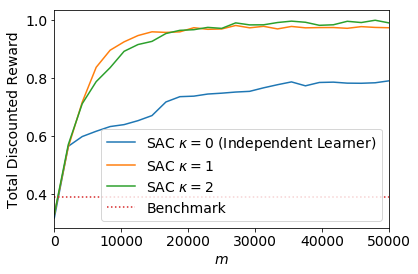

In [16]:
plt.rc('font', size=14)  


print('average reward calculated by averaging = ', finalRewardList)
legendStr = []
for kInd in range(maxK+1):
    plt.plot(np.linspace(1,M,len(policyRewardSmooth)), policyRewardSmoothList[kInd])
    if kInd == 0:
        legendStr.append('SAC $\kappa = '+str(kInd)+'$ (Independent Learner)')
    else:
        legendStr.append('SAC $\kappa = '+str(kInd)+'$')

plt.plot(np.linspace(1,M,len(policyRewardSmooth)), benchMarkReward*np.ones(len(policyRewardSmooth),dtype = float), linestyle = ':')
legendStr.append('Benchmark')
plt.xlim(0,M)
plt.legend(legendStr, loc = 'lower right')
plt.ylabel('Total Discounted Reward')
plt.xlabel('$m$')
plt.savefig('Aug21Figs/36gridk02_new_2.png',bbox_inches='tight')

plt.show()


In [17]:
# # saving the data
import pickle 

with open('Aug21Figs/36gridk02_new_2.pkl','wb') as f:
     pickle.dump([benchMarkReward,policyRewardSmoothList],f)

In [15]:
# tuning the Benchmark
#benchMarkReward = networkRLModel.evaluateBenchmarkPolicy(evalM , T)
